# Time-Series/Panel Data

1. autocorrelation
2. partial autocorrelation
2. cross-correlation
3. AR models
4. ARMA models
5. ARIMA models
6. Fourier transform
7. Power spectrum 
7. Cepstrum
8. Singular Spectrum Analysis
9. Imaging time-series

#### To do
* cluster on cumulative plots for event counts for each unit
* factor analysis
* try out altair visualisations
* keras LSTM for time-series predictions

#### Useful online tutorials
* https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a

#### Useful literature
* Box, George EP, et al. Time series analysis: forecasting and control. John Wiley & Sons, 2015.
* Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018 (http://otexts.org/fpp2/).

#### Packages
* tsfresh
* statsmodels.tsa

## Preliminaries

In [1]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np
import pandas as pd
import os
from pysf.data import download_ramsay_weather_data_dfs

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

ModuleNotFoundError: No module named 'pysf'

In [ ]:
def download_gunpoint_data():
    url = 'http://www.timeseriesclassification.com/Downloads/GunPoint.zip'
    url = urlopen(url)
    zipfile = ZipFile(BytesIO(url.read()))

    train_file = zipfile.open('GunPoint_TRAIN.txt')
    X_train, y_train = read_data(train_file)

    test_file = zipfile.open('GunPoint_TEST.txt')
    X_test, y_test = read_data(test_file)
    
    def read_data(file):
        data = file.readlines()
        rows = [row.decode('utf-8').strip().split('  ') for row in data]
        X = pd.DataFrame(rows, dtype=np.float)
        y = X.pop(0)
    
    return X_train, y_train, X_test, y_test

Download data

In [2]:
data, _ = download_ramsay_weather_data_dfs()
data.head()

NameError: name 'download_ramsay_weather_data_dfs' is not defined

# Time-series exploratory analysis
time series is here understood as a sequence of values with a time index, usually recorded in equal and fixed intervals

Select single series for precipitation and temperature

In [3]:
precav = data.loc[data.weather_station == 0, 'precav']
precav.head()

NameError: name 'data' is not defined

In [4]:
precav.shape

NameError: name 'precav' is not defined

In [8]:
tempav = data.loc[data.weather_station == 0, 'tempav']
tempav.head()

0   -3.6
1   -3.1
2   -3.4
3   -4.4
4   -2.9
Name: tempav, dtype: float64

In [9]:
tempav.shape

(365,)

Split by time into training and test sets for evaluating forecasts 

In [8]:
train = precav[:100]
test = precav[100:110]
end = train.shape[0] + test.shape[0]-1
start = train.shape[0]
print(train.shape, test.shape)

(100,) (10,)


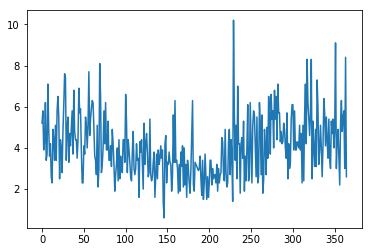

In [9]:
precav.plot();

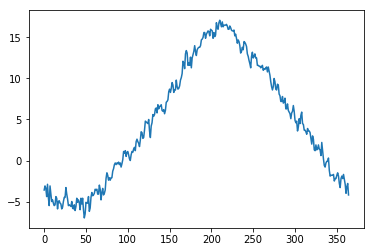

In [10]:
tempav.plot();

## Autocorrelation

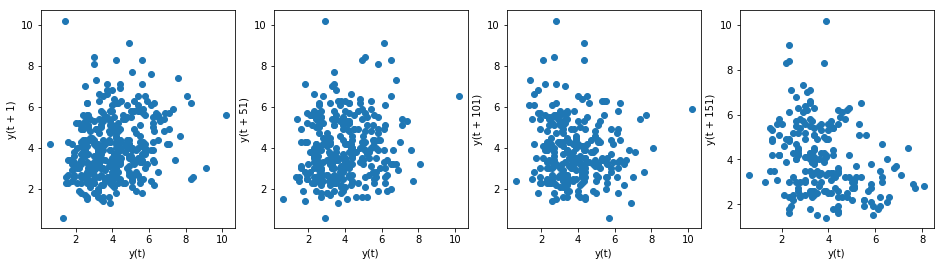

In [212]:
from pandas.plotting import lag_plot
lags = np.arange(0, 200, 50) + 1
fig, axs = plt.subplots(ncols=4, figsize=plt.figaspect(.25))
for k, lag in enumerate(lags):
    lag_plot(precav, lag=lag, ax=axs[k]);

For estimation of autocorrelation, see e.g.
* https://en.wikipedia.org/wiki/Autocorrelation#Estimation
* https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.autocorrelation

In [12]:
def estimate_autocorrelation(x, lags=None):
    """
    Estimate autocorrelation for x, see e.g. 
    Time-Series Analysis: Forecasting and Control, 
    4th ed. (Box, Jenkins, Reinsel), p31
    """
    data = np.asarray(x) 
    n = data.shape[0]
    mu = data.mean()
    c_0 = np.sum((data - mu)**2) / float(n)
    def r(k):
        """
        Estimate autocorrelation at lag k (sample autocorrelation function).
        """
        return np.sum((data[:n - k] - mu) * 
                      (data[k:] - mu)) / float(n) / c_0
    if lags is None:
        lags = np.arange(n) + 1
    
    rs = np.array(list(map(r, lags)))
    return rs

In [13]:
estimate_autocorrelation(precav)[:10]

array([0.22174835, 0.18069703, 0.27823565, 0.16903308, 0.22345252,
       0.16952763, 0.18895724, 0.21323924, 0.20947961, 0.22356417])

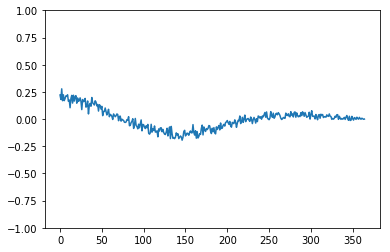

In [14]:
fig, ax = plt.subplots(1)
ax.plot(estimate_autocorrelation(precav))
ax.set(ylim=(-1,1));

Same results can be obtained and plotted with confidence intervals using pandas 
* https://en.wikipedia.org/wiki/Correlogram

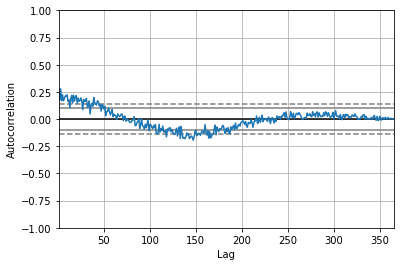

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(precav);

In [9]:
from statsmodels.tsa.stattools import acf
acf(precav)

NameError: name 'precav' is not defined

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(precav);

## Partial Autocorrelation Function

In [3]:
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
plot_pacf(precav);

NameError: name 'precav' is not defined

In [5]:
plot_pacf(precav, method='ld', lags=np.arange(260, 300));

NameError: name 'precav' is not defined

In [22]:
from statsmodels.tsa.stattools import pacf
pacf(precav)[:10]

array([1.        , 0.22235755, 0.13912864, 0.23046037, 0.06536205,
       0.13934595, 0.03983444, 0.09090922, 0.08923004, 0.09933892])

## Cross-correlation
* also see `from skimage.feature import match_template`

Cross-correlations are useful for determining the time delay between two signals. After calculating the cross-correlation, the maximum (or minimum) of the cross-correlation function indicates the point in time where the signals are best aligned (using `np.argmax()` or `np.argmin()`)

In [23]:
def estimate_crosscorrelation(x, y, lags=None):
    """
    Estimate cross-correlation for series x, y of equal length, see e.g. 
    Time-Series Analysis: Forecasting and Control, 
    4th ed. (Box, Jenkins, Reinsel), p477
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    if x.shape[0] != y.shape[0]:
        raise ValueError('Input series must be of the same length.')
    
    n = x.shape[0]
    mu_x = x.mean()
    mu_y = y.mean()
    
    # compute cross-covariance coefficient at lag k
    def c(k):
        if k > 0:
            return np.sum((x[:n - k] - mu_x) * 
                      (y[k:] - mu_y)) / float(n)
        else:
            return np.sum((y[:n + k] - mu_y) * 
                      (x[-k:] - mu_x)) / float(n)
     
    if lags is None:
        lags = np.arange(-n, n) + 1
    
    # compute for all lags
    c_xy = np.array(list(map(c, lags)))
    
    # normalise with standard deviations to values between -1 and +1
    s_xy = np.std(x) * np.std(y)
    r_xy = c_xy / s_xy
    
    return r_xy

def plot_crosscorrelation(x, y, lags=None, ax=None):
    if x.shape[0] != y.shape[0]:
        raise ValueError('Input series must be of the same length.')
    n = x.shape[0]
    
    if ax is None:
        fig, ax = plt.subplots(1)
    
    if lags is None:
        lags = np.arange(-n, n) + 1
    
    xcorr = estimate_crosscorrelation(x, y, lags=lags)
    ax.plot(lags, xcorr)
    
    # confidence intervals
    stderr = np.sqrt(1 / (n - lags))
    z95 = 1.959963984540054
    z99 = 2.5758293035489004    
    lower_ci95 = -z95 * stderr
    upper_ci95 = z95 * stderr
    lower_ci99 = -z99 * stderr
    upper_ci99 = z99 * stderr
    ax.axhline(y=0.0, color='black')
    ax.plot(lags, lower_ci95, color='grey')
    ax.plot(lags, upper_ci95, color='grey')
    ax.plot(lags, lower_ci99, color='grey', linestyle='--')
    ax.plot(lags, upper_ci99, color='grey', linestyle='--')
    
#     # confidence intervals
#     z95 = 1.959963984540054
#     z99 = 2.5758293035489004
#     ax.axhline(y=z99 / np.sqrt(n), linestyle='--', color='grey')
#     ax.axhline(y=z95 / np.sqrt(n), color='grey')
#     ax.axhline(y=0.0, color='black')
#     ax.axhline(y=-z95 / np.sqrt(n), color='grey')
#     ax.axhline(y=-z99 / np.sqrt(n), linestyle='--', color='grey')

    ax.set(ylabel='Cross-correlation', xlabel='Lag', ylim=(-1, 1),
           xlim=(lags.min(), lags.max()));
    return ax

/Users/mloning/.conda/envs/timeseries/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


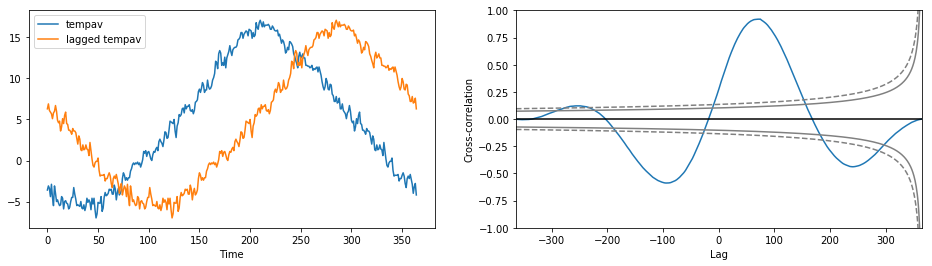

In [200]:
lagged_tempav = np.empty(n)
lag = 75
lagged_tempav[:lag] = tempav[-lag:]
lagged_tempav[lag:] = tempav[:-lag]

fig, axs = plt.subplots(ncols=2, figsize=plt.figaspect(.25))
axs[0].plot(tempav, label='tempav')
axs[0].plot(lagged_tempav, label='lagged tempav')
axs[0].legend()
axs[0].set(xlabel='Time')
plot_crosscorrelation(tempav, lagged_tempav, ax=axs[1]);

## Auto-regressive model (AR)
* for using the estimated AR coefficient as features, see e.g.  https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/feature_extraction/feature_calculators.html#ar_coefficient

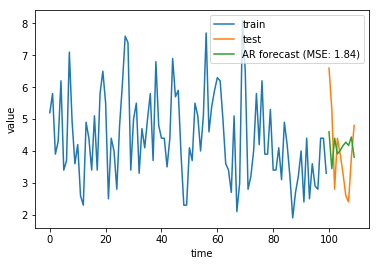

In [187]:
model = AR(train)
model_fit = model.fit()
forecasts = model_fit.predict(start=train.shape[0], end=train.shape[0]+test.shape[0]-1)
mse = mean_squared_error(test, forecasts)
fig, ax = plt.subplots(1)
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(forecasts, label=f'AR forecast (MSE: {np.round(mse, 2)})')
ax.set(ylabel='value', xlabel='time')
ax.legend();

In [451]:
model_fit.params[:5]

const            -0.011344
ar.L1.D.precav   -0.138446
ar.L2.D.precav   -0.019074
ar.L3.D.precav    0.105127
ma.L1.D.precav   -0.571233
dtype: float64

## Auto-regressive moving average model (ARMA)

/Users/mloning/.conda/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


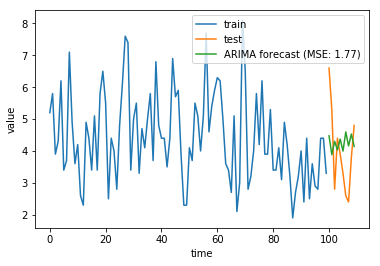

In [221]:
model = ARMA(train, (11, 2))
model_fit = model.fit()
forecasts = model_fit.predict(start=start, end=end)
mse = mean_squared_error(test, forecasts)
fig, ax = plt.subplots(1)
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(forecasts, label=f'ARIMA forecast (MSE: {np.round(mse, 2)})')
ax.set(ylabel='value', xlabel='time')
ax.legend()

In [222]:
model_fit.params.shape

(14,)

* tsfresh has calculator for AR models, but not for ARMA or ARIMA (https://tsfresh.readthedocs.io/en/latest/_modules/tsfresh/feature_extraction/feature_calculators.html#ar_coefficient)

In [452]:
from statsmodels.tsa.arima_model import ARMA
from numpy.linalg import LinAlgError
from itertools import product

def compute_arma_coefficient(series, param):
    """
    Estimate coefficient of ARMA model.
    
    param: dictionary {'coeff': x, 'p': y, 'q': z} with x, y, z int
    """
    data = np.asarray(series)
    n = data.shape[0]
    p = param['p']
    q = param['q']
    model = ARMA(data, (p, q))
    try:
        fitted_model = model.fit()
        coeffs = fitted_model.params
    except (LinAlgError, ValueError):
        n_coeffs = q * p + 1
        coeffs = np.full(n_coeffs, fill_value=np.nan)
    return coeffs

Estimate coefficients for different combinations of parameters

In [268]:
params = {'p': [0, 1, 2, 3, 4], 'q': [0, 1, 2]}
results = {}
for p, q in product(*params.values()):
    param = {'p': p, 'q': q}
    results_name = f'{p}_{q}'
    results[results_name] = compute_arma_coefficient(precav, param)

In [274]:
results['3_0']

array([4.06512033, 0.15876321, 0.09202504, 0.23382917])

## Arima models
some bug in Arima model, same syntax as AR model above, but breaks?

In [276]:
model = ARIMA(train, (3, 1, 2))
model_fit = model.fit()
forecasts = model_fit.predict(start=start, end=end)
mse = mean_squared_error(test, forecasts)
fig, ax = plt.subplots(1)
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(forecasts, label=f'ARIMA forecast (MSE: {np.round(mse, 2)})')
ax.set(ylabel='value', xlabel='time')
ax.legend()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

## Fourier transforms
Fourier transform decomposes a function of time (i.e. a time series) into the frequencies that make it up
* https://docs.scipy.org/doc/numpy/reference/routines.fft.html
* also see tsfresh implementation

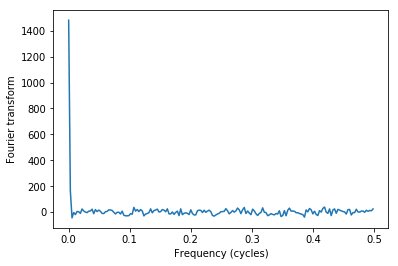

In [825]:
fft = np.fft.rfft(precav)
n = precav.shape[0]
freqs = np.fft.fftfreq(n, d=1)[:n//2+1]
fig, ax = plt.subplots(1)
ax.plot(freqs, fft)
ax.set(xlabel='Frequency (cycles)', ylabel='Fourier transform');

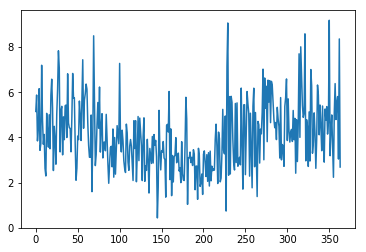

In [820]:
# inverse transform
plt.plot(np.fft.irfft(fft));

## Power spectrum

(183,)


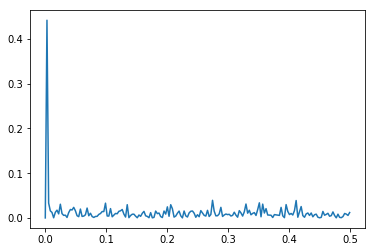

In [456]:
from scipy.signal import periodogram
freqs, ps = periodogram(precav, return_onesided=True, 
                        scaling='spectrum', window='boxcar')
print(ps.shape)
plt.plot(freqs, ps);

(129,)


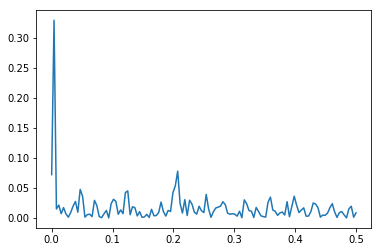

In [457]:
from scipy.signal import welch
freqs, ps = welch(precav, return_onesided=True, 
                  scaling='spectrum')
print(ps.shape)
plt.plot(freqs, ps);

## Cepstrum

* https://github.com/python-acoustics/python-acoustics

In [738]:
def compute_complex_cepstrum(x, n=None):
    def _unwrap(phase):
            samples = phase.shape[-1]
            unwrapped = np.unwrap(phase)
            center = (samples+1)//2
            if samples == 1:
                center = 0
            ndelay = np.array(np.round(unwrapped[...,center]/np.pi))
            unwrapped -= np.pi * ndelay[...,None] * np.arange(samples) / center
            return unwrapped, ndelay

    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)) + 1j*unwrapped_phase
    ceps = np.fft.ifft(log_spectrum).real
    
    return ceps, ndelay

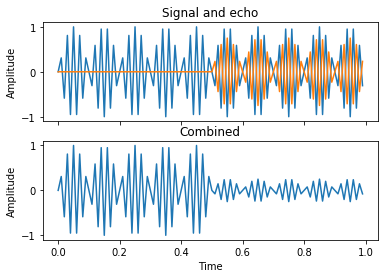

In [790]:
# generate sine of frequency 45 Hz, sampled at 100 Hz
signal_freq = 45 
sample_freq = 100
t = np.arange(0, 1, 1/sample_freq)
n = t.shape[0]
s1 = np.sin(2 * np.pi * signal_freq * t)
# add echo with half the amplitued and with some delay later
delay = 50
echo = 0.75 * np.concatenate([np.zeros(delay), s1[:n-delay]])
s2 = s1 + echo
fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(t, s1, label='Signal')
axs[0].plot(t, echo, label='Echo')
axs[0].set(title='Signal and echo', ylabel='Amplitude');
axs[1].plot(t, s2)
axs[1].set(title='Combined', xlabel='Time', ylabel='Amplitude');

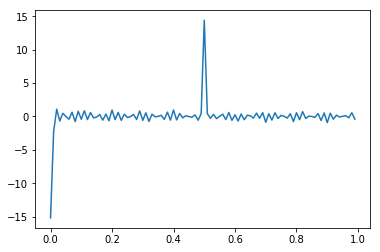

In [791]:
# notice echo at delay
cceps, _ = compute_complex_cepstrum(s2)
plt.plot(t, cceps);

In [792]:
def compute_real_cepstum(x, n=None):
    spectrum = np.fft.fft(x, n=n)
    rceps = np.fft.ifft(np.log(np.abs(spectrum))).real
    return rceps

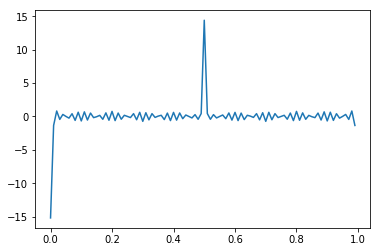

In [793]:
rceps = compute_real_cepstum(s2)
plt.plot(t, rceps);

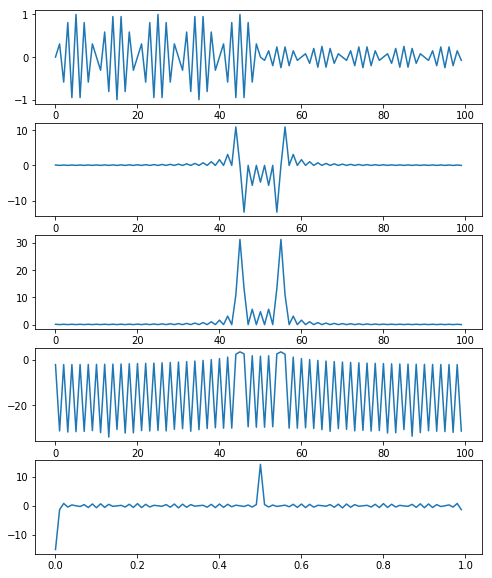

In [826]:
# steps of cepstrum
fig, axs = plt.subplots(nrows=5, figsize=(8,10))
axs[0].plot(s2)
fft = np.fft.fft(s2)
axs[1].plot(fft)
abs_fft = np.abs(fft)
axs[2].plot(abs_fft)
log_abs_fft = np.log(abs_fft)
axs[3].plot(log_abs_fft);
ifft_log_abs_fft = np.fft.ifft(log_abs_fft)
axs[4].plot(t, ifft_log_abs_fft);

## Singular Spectrum Analysis
https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

In [10]:
from pyts.decomposition import SSA

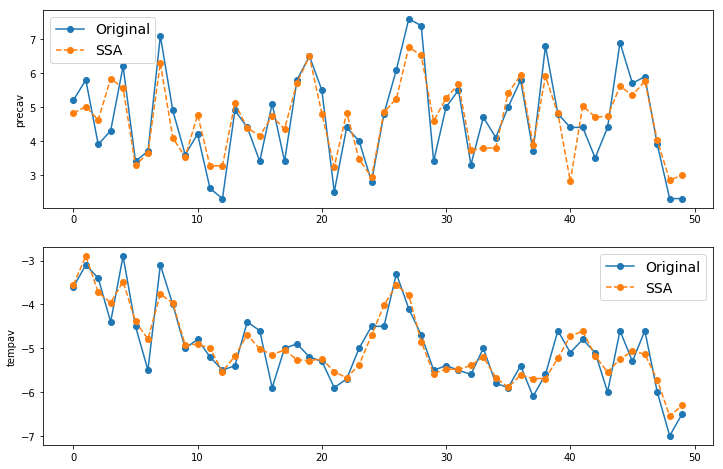

In [75]:
window_size = 250
ssa = SSA(window_size=window_size)
precav_array = np.array(precav).reshape(1, -1)
precav_ssa = ssa.fit_transform(precav_array)

tempav_array = np.array(tempav).reshape(1, -1)
tempav_ssa = ssa.fit_transform(tempav_array)

n_obs = 50 # zoom into first few observations
n_components = 50 # components to reconstruct series
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))
axs[0].plot(precav[:n_obs], 'o-', label='Original')
axs[0].plot(precav_ssa[0, :n_components, :n_obs].sum(axis=0), 'o--', label='SSA')
axs[0].legend(loc='best', fontsize=14)
axs[0].set(ylabel='precav')

axs[1].plot(tempav[:n_obs], 'o-', label='Original')
axs[1].plot(tempav_ssa[0, :n_components, :n_obs].sum(axis=0), 'o--', label='SSA')
axs[1].legend(loc='best', fontsize=14)
axs[1].set(ylabel='tempav');

## Imaging time series
* https://arxiv.org/pdf/1506.00327.pdf

/Users/mloning/.conda/envs/timeseries/lib/python3.7/site-packages/pyts/image/image.py:321: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  MTF[np.meshgrid(list_values[i], list_values[j])] = MTM[i, j]
/Users/mloning/.conda/envs/timeseries/lib/python3.7/site-packages/pyts/image/image.py:321: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  MTF[np.meshgrid(list_values[i], list_values[j])] = MTM[i, j]


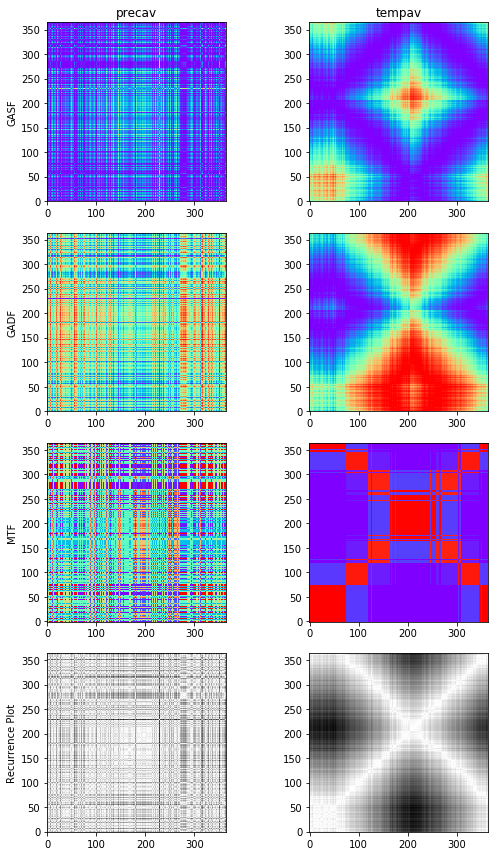

In [120]:
from pyts.image import GASF, GADF, MTF, RecurrencePlots

# GAF transformations
image_size = 365
gasf = GASF(image_size=image_size)
precav_gasf = gasf.fit_transform(precav_array)
tempav_gasf = gasf.fit_transform(tempav_array)

gadf = GADF(image_size=image_size)
precav_gadf = gadf.fit_transform(precav_array)
tempav_gadf = gadf.fit_transform(tempav_array)

mtf = MTF(image_size=image_size)
precav_mtf = mtf.fit_transform(precav_array)
tempav_mtf = mtf.fit_transform(tempav_array)

rp = RecurrencePlots()
precav_rp = rp.fit_transform(precav_array)
tempav_rp = rp.fit_transform(tempav_array)


# Show the results for the first time series
plt.figure(figsize=(8, 12))
plt.subplot(421)
plt.title('precav')
plt.ylabel('GASF')
plt.imshow(precav_gasf[0], cmap='rainbow', origin='lower')

plt.subplot(422)
plt.title('tempav')
plt.imshow(tempav_gasf[0], cmap='rainbow', origin='lower')

plt.subplot(423)
plt.ylabel('GADF')
plt.imshow(precav_gadf[0], cmap='rainbow', origin='lower')

plt.subplot(424)
plt.imshow(tempav_gadf[0], cmap='rainbow', origin='lower')

plt.subplot(425)
plt.ylabel('MTF')
plt.imshow(precav_mtf[0], cmap='rainbow', origin='lower')

plt.subplot(426)
plt.imshow(tempav_mtf[0], cmap='rainbow', origin='lower')

plt.subplot(427)
plt.ylabel('Recurrence Plot')
plt.imshow(precav_rp[0], cmap='binary', origin='lower')

plt.subplot(428)
plt.imshow(tempav_rp[0], cmap='binary', origin='lower')

plt.tight_layout();

## Comparing time-series

In [565]:
# simulate simple AR(1) series
n = 100

alpha = np.empty(n)
alpha_0 = np.random.normal()

alpha[0] = alpha_0
z1 = np.empty(n)
for t in np.arange(1, n):
    alpha[t] = np.random.normal()
    z1[t] = alpha[t] + alpha[t-1]
    
alpha = np.empty(n)
alpha[0] = alpha_0
z2 = np.empty(n)
for t in np.arange(1, n):
    alpha[t] = np.random.normal()
    z2[t] = + alpha[t] - alpha[t-1]

In [859]:
# ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
# ax4 = plt.subplot2grid((3, 3), (2, 0))
# ax5 = plt.subplot2grid((3, 3), (2, 1))

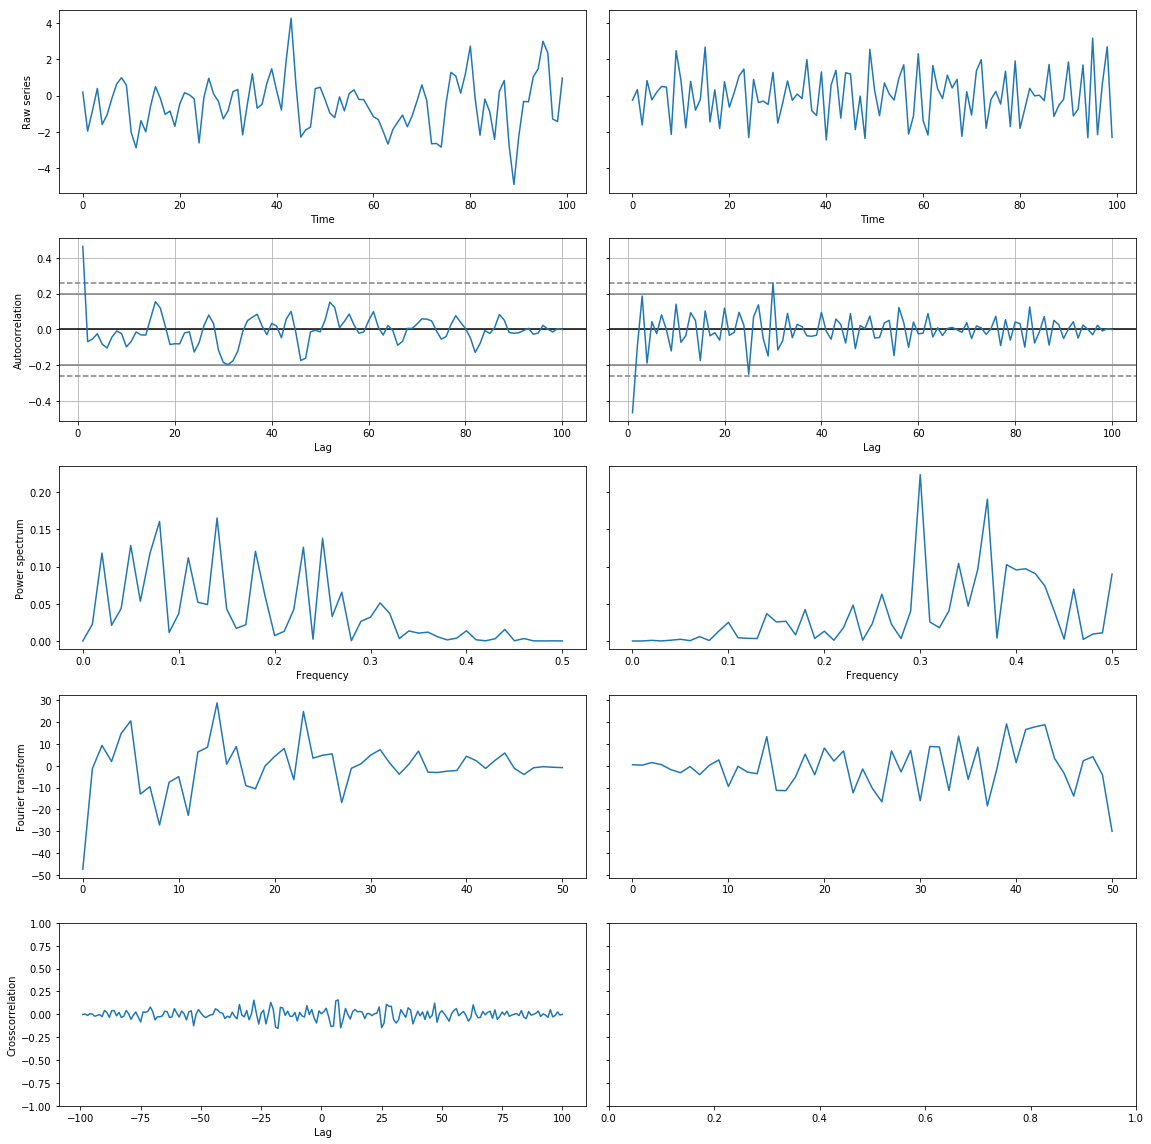

In [795]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(16,16), sharey='row')
pd.Series(z1).plot(ax=axs[0,0])
axs[0,0].set(ylabel='Raw series', xlabel='Time')
pd.Series(z2).plot(ax=axs[0,1])
axs[0,1].set(ylabel='Raw series', xlabel='Time')
autocorrelation_plot(z1, ax=axs[1,0]);
autocorrelation_plot(z2, ax=axs[1,1]);

freqs, ps = periodogram(z1, return_onesided=True, 
                        scaling='spectrum', window='boxcar')
axs[2,0].plot(freqs, ps)
axs[2,0].set(ylabel='Power spectrum', xlabel='Frequency')
freqs, ps = periodogram(z2, return_onesided=True, 
                        scaling='spectrum', window='boxcar')
axs[2,1].plot(freqs, ps)
axs[2,1].set(ylabel='Power spectrum', xlabel='Frequency')
pd.Series(np.fft.rfft(z1)).plot(ax=axs[3,0])
axs[3,0].set(ylabel='Fourier transform')
pd.Series(np.fft.rfft(z2)).plot(ax=axs[3,1])
axs[3,1].set(ylabel='Fourier transform')
plot_crosscorrelation(z1, z2, ax=axs[4,0])
plt.tight_layout();

## Other time-series transformations
for
* Piecewise Aggregate Approximation (PAA)
* Symbolic Aggregate Approximation (SAX)
* Symbolic Fourier Approximation (SFA)
* Bag of Patterns (with SAX or SFA)

see e.g. 
https://github.com/johannfaouzi/pyts or `tslearn`

## Shapelets
* for an introduction to time-series shapelets, see e.g. http://alumni.cs.ucr.edu/%7Elexiangy/Shapelet/kdd2009shapelet.pdf 
* for an implementation, see e.g. `tslearn`

# Panel data exploratory analysis

# Supervised learning

## Dynamic Time Warping with kNN classifier

In [134]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric='dtw')
clf.fit(np.array(X_train), np.array(y_train))
clf.score(np.array(X_test), np.array(y_test))

0.9066666666666666